# レスラー方程式（外力のある場合）

外力のない場合のレスラー方程式の予測はそれなりにうまく行った気がする．
次は外力のある場合のレスラー方程式の予測を行ってみる．

注．hyperoptが同じhyperparametersを返してしまう問題だが，train_lenを10000にすることによって回避できた．
単純に学習期間が不足していたのかもしれない．

In [32]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [33]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# 外力P(t)の振幅Aをパラメータとして追加します。
A = 0.1  # 外力の振幅を設定します。この値を変更することで、外力の強さを変えられます。

# レスラー方程式の定義を変更して、外力P(t)を加えます。
def rossler_system_with_force(t, state, a, b, c):
    x, y, z = state
    dxdt = -y - z + A * np.sin(t)  # X項に外力P(t)を加える
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# パラメータ
a = 0.2
b = 0.2
c = 5.7

# 初期条件
initial_state = [1.0, 1.0, 1.0]

# 時間の設定
t_span = [0, 2510]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 25100)  # 評価する時間点


# 微分方程式の数値解を求める
solution_with_force = solve_ivp(rossler_system_with_force, t_span, initial_state, args=(a, b, c), t_eval=t_eval, max_step=0.01)

# 外力P(t)の計算
P = A * np.sin(solution_with_force.t)

# CSVファイルにデータを保存するためのDataFrameを作成
data_frame_with_force = pd.DataFrame({
    'time': solution_with_force.t,
    'x': solution_with_force.y[0],
    'y': solution_with_force.y[1],
    'z': solution_with_force.y[2],
    'P': P  # 外力P(t)の列を追加
})

# CSVファイルにデータを保存
filename_with_force = 'rossler_data_with_force1.3.1.csv'
data_frame_with_force.to_csv(filename_with_force, index=False)

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P']].values

print(X)

[[ 1.          1.          0.        ]
 [ 0.8143561   1.11164722  0.00998374]
 [ 0.64878658  1.20790655  0.01986771]
 ...
 [-4.88427402  7.01678759  0.03264432]
 [-5.56651533  6.63051689  0.02304443]
 [-6.2071844   6.16955935  0.01321426]]


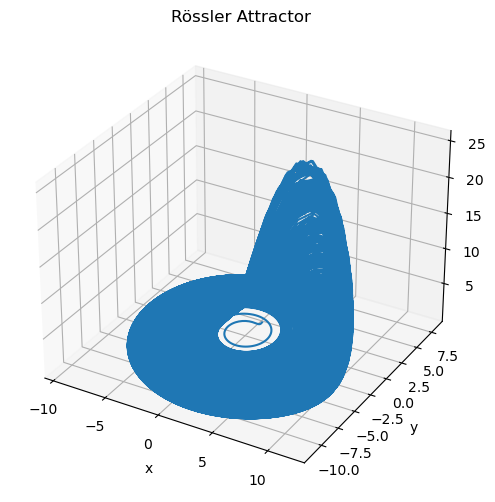

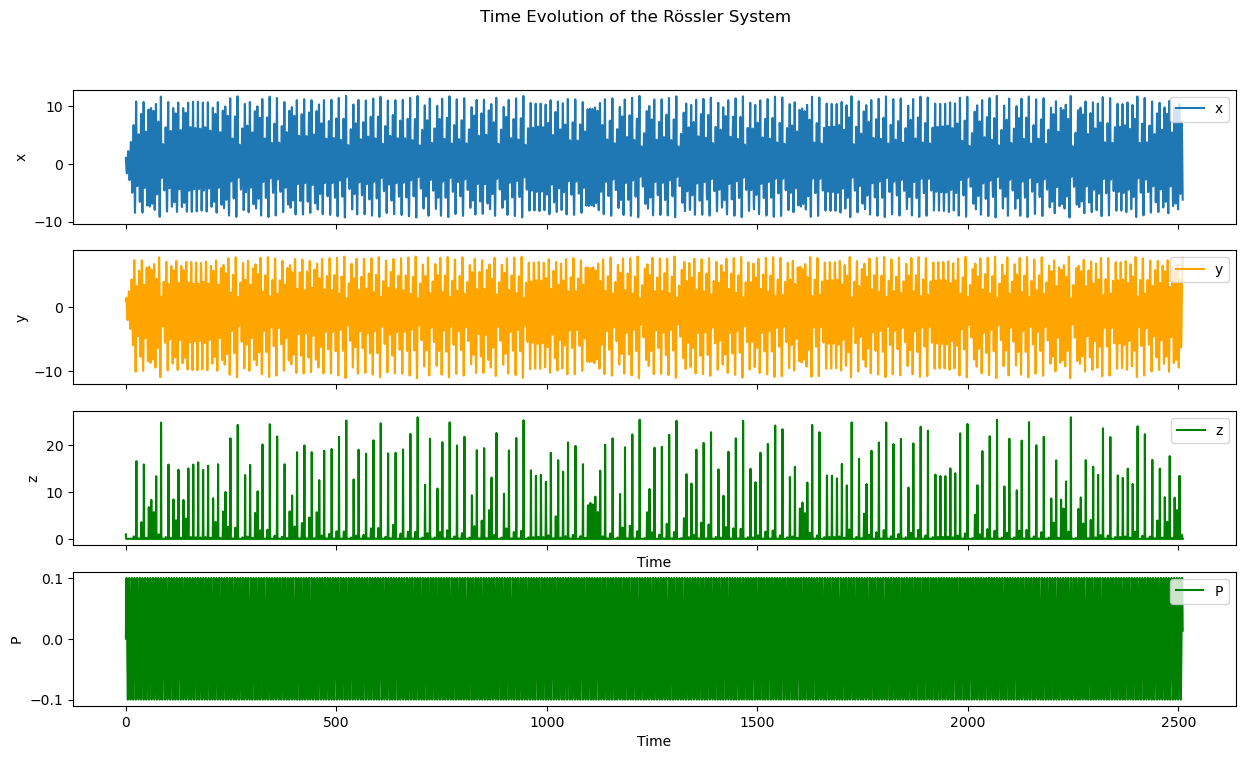

In [34]:
# XYZの三次元グラフをプロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_frame_with_force['x'], data_frame_with_force['y'], data_frame_with_force['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rössler Attractor')
plt.show()

sample = 1000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_frame_with_force['time'], data_frame_with_force['x'], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_frame_with_force['time'], data_frame_with_force['y'], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

axs[2].plot(data_frame_with_force['time'], data_frame_with_force['z'], label='z', color='green')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Time')
axs[2].legend(loc='upper right')

axs[3].plot(data_frame_with_force['time'], data_frame_with_force['P'], label='P', color='green')
axs[3].set_ylabel('P')
axs[3].set_xlabel('Time')
axs[3].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()


ここまで，正しくシミュレーションが出来た．

実際にESNを用いる際に扱うデータはXであるが，これはレスラー方程式のx, y項のみを含む二次元の配列である．

In [35]:
X.shape

(25100, 3)

### 2. hyperoptを用いたESNのパラメータの最適化

ESNを用いる際に決定しなければならないhyperparameterの初期値をhyperoptを用いて最適化する．

注．quniformの使い方に慣れていないが，ここでは自分で整数に丸めて使うことにする．

In [36]:
from hyperopt import hp, tpe, Trials, fmin

In [37]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    N_value = int(N)  # Nを整数に変換    

    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N_value, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        prediction = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, prediction, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, prediction)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [38]:
hyperopt_config = {
    "exp": f"hyperopt-rossler_with_force1.3.1", # the experimentation name
    "hp_max_evals": 300,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["quniform", 500, 5000, 1],  # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 5555]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [39]:
from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [40]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

  2%|▏         | 5/300 [07:10<4:57:15, 60.46s/trial, best loss: 0.0002945216876033546]  

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.63351e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.60598e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.94e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



  3%|▎         | 10/300 [17:00<8:54:59, 110.69s/trial, best loss: 0.0002945216876033546]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.63735e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



  7%|▋         | 21/300 [32:07<4:19:07, 55.73s/trial, best loss: 0.0002945216876033546]  

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.08574e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.05741e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.08517e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 13%|█▎        | 38/300 [1:12:25<7:10:45, 98.65s/trial, best loss: 0.00010753192995871428]  

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.10365e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.07907e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 13%|█▎        | 40/300 [1:15:29<6:20:19, 87.77s/trial, best loss: 0.00010753192995871428] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.92963e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.41015e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.488e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 29%|██▉       | 87/300 [2:31:16<5:13:24, 88.29s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.81709e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 29%|██▉       | 88/300 [2:32:10<4:36:01, 78.12s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.3637e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.88579e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.01854e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 31%|███       | 93/300 [2:40:04<6:10:57, 107.52s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.15715e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.40342e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.36868e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 33%|███▎      | 98/300 [2:42:37<2:32:32, 45.31s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.22845e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.02256e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 39%|███▉      | 118/300 [3:51:05<6:45:42, 133.75s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.46087e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.45483e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.57943e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 50%|█████     | 151/300 [4:41:14<3:13:44, 78.01s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.00302e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.02644e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.00508e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 54%|█████▍    | 162/300 [4:55:19<3:02:34, 79.38s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.01424e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 55%|█████▍    | 164/300 [4:59:20<3:58:26, 105.20s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.029e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 56%|█████▋    | 169/300 [5:06:26<2:58:07, 81.58s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.59426e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.61485e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.66207e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 57%|█████▋    | 170/300 [5:06:42<2:14:03, 61.87s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.52711e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.63358e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.8835e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 62%|██████▏   | 186/300 [5:45:07<3:51:40, 121.93s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.52172e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 67%|██████▋   | 200/300 [6:08:04<3:24:39, 122.79s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.08677e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.49296e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.12759e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 68%|██████▊   | 204/300 [6:14:59<2:03:57, 77.47s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.08643e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.79395e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 68%|██████▊   | 205/300 [6:15:38<1:44:40, 66.11s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.06287e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.34961e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.22818e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 72%|███████▏  | 215/300 [6:29:53<2:07:35, 90.06s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.05382e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 73%|███████▎  | 220/300 [6:41:33<3:06:35, 139.94s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.78639e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.95146e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 76%|███████▌  | 227/300 [6:48:35<1:12:18, 59.42s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.84664e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.54169e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 80%|████████  | 240/300 [7:08:39<1:54:51, 114.85s/trial, best loss: 1.0325768067404364e-06]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.12552e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.25355e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.95333e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 82%|████████▏ | 246/300 [7:11:38<43:04, 47.86s/trial, best loss: 1.0325768067404364e-06]   

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.71362e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.4601e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.76651e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 85%|████████▌ | 255/300 [7:25:28<1:08:11, 90.92s/trial, best loss: 1.0325768067404364e-06] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.44774e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.41411e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.3853e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 87%|████████▋ | 261/300 [7:34:28<59:17, 91.22s/trial, best loss: 1.0325768067404364e-06]   

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.09902e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.3459e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.26948e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 91%|█████████ | 273/300 [7:51:14<37:52, 84.15s/trial, best loss: 8.756337025196858e-07]   

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.6073e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.51468e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.65692e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



100%|██████████| 300/300 [8:22:49<00:00, 100.57s/trial, best loss: 8.756337025196858e-07]


In [42]:
# `best`タプルの最初の要素には最適化されたハイパーパラメータが直接含まれています
best_params = best[0]

# numpy int64型をPythonのint型に変換するための関数
def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError

# 最適なハイパーパラメータをJSONファイルに保存
with open(f"{hyperopt_config['exp']}_best_params.json", 'w') as f:
    json.dump(best_params, f, default=convert)

In [41]:
best

({'N': 4477.0,
  'iss': 0.0847552772285739,
  'lr': 0.4589596869564032,
  'ridge': 4.843985123099407e-09,
  'seed': 0,
  'sr': 0.8361142665850508},
 <hyperopt.base.Trials at 0x17c2ba850>)